# 보스톤 주택 가격 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

- DataFrame으로 준비

In [3]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(data, columns=feature_names)
df['PRICE'] = target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
data.shape, target.shape

((506, 13), (506,))

## 1. 데이터 탐색

 ```
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
 ```

* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* PRICE: 본인 소유의 주택 가격(중앙값)

- 누락 데이터 확인

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [6]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

- 통계 정보

In [7]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


- 수치형 데이터 시각화(히스토그램)

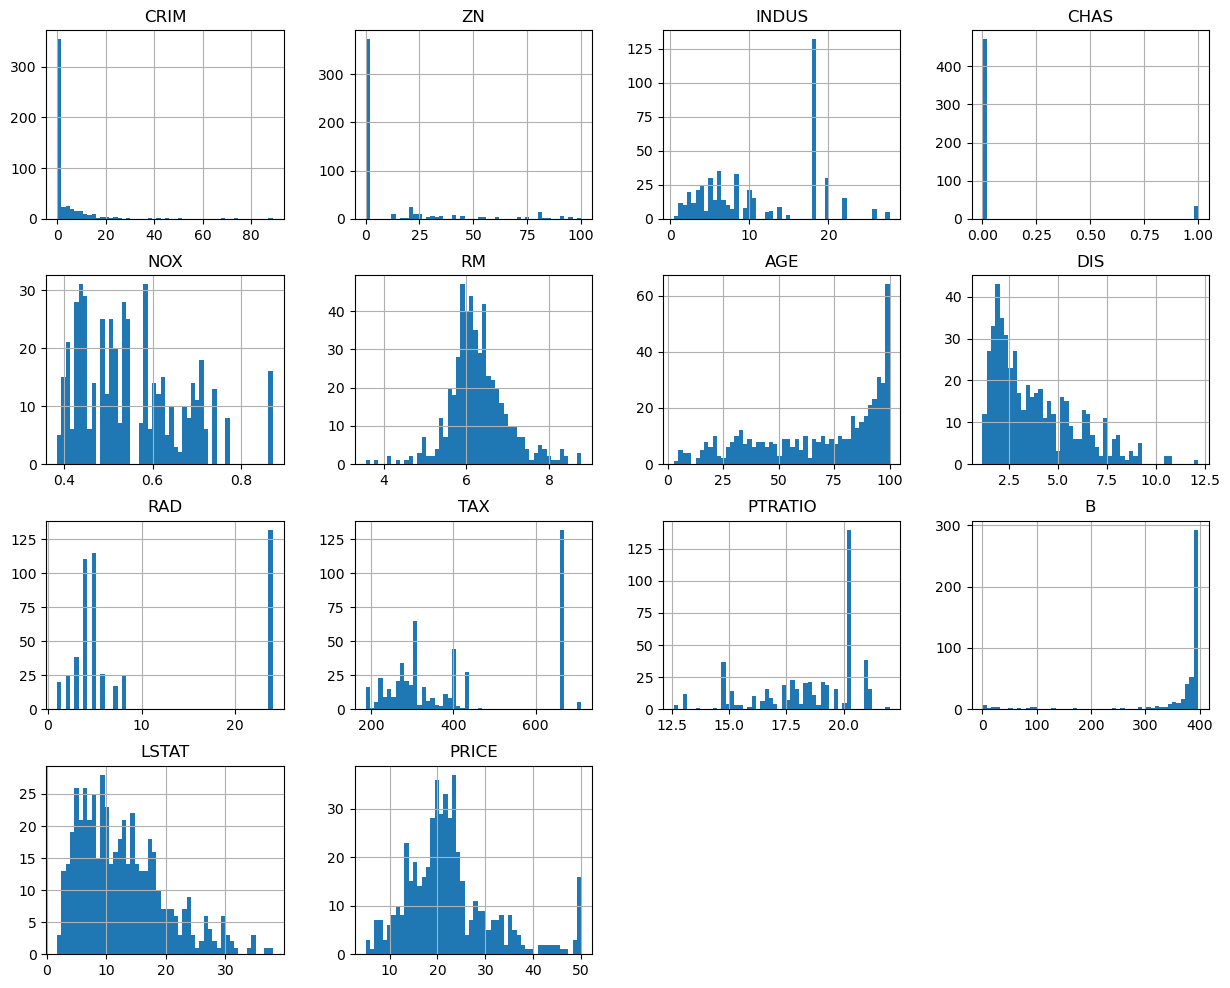

In [8]:
df.hist(bins=50, figsize=(15, 12))
plt.show()

- 상관계수

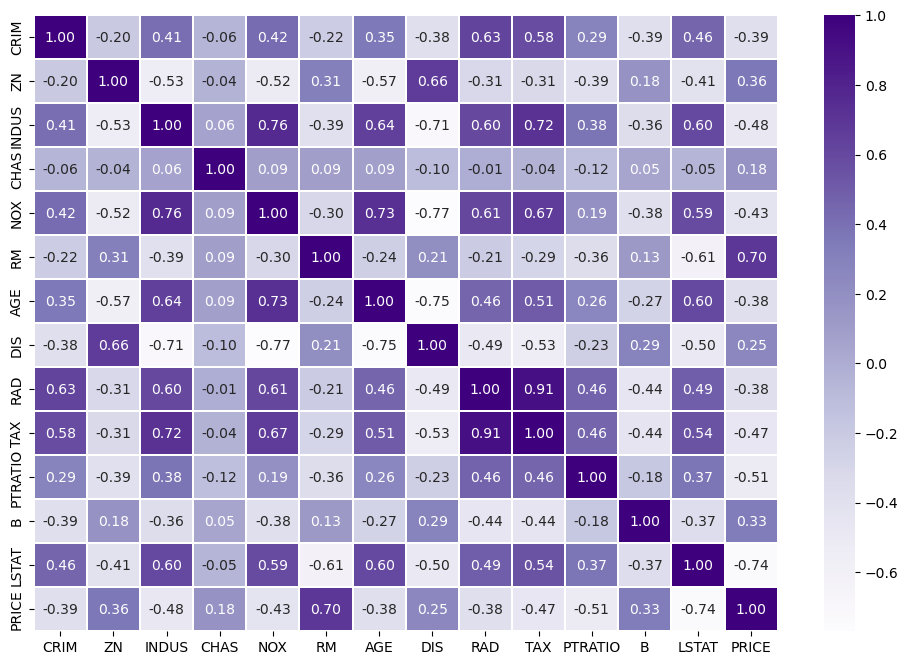

In [9]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(data=corr, annot=True, fmt='.2f', cmap='Purples', lw=0.25)
plt.show()

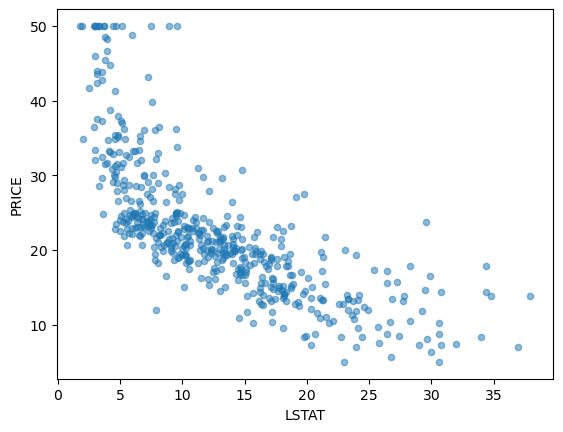

In [10]:
# 음의 상관관계
df.plot(kind='scatter', x='LSTAT', y='PRICE', alpha=0.5)
plt.show()

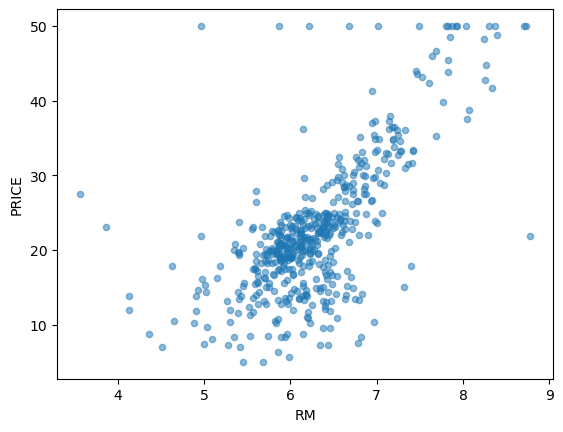

In [11]:
# 양의 상관관계
df.plot(kind='scatter', x='RM', y='PRICE', alpha=0.5)
plt.show()

## 2. 데이터 준비(데이터 세트 분리)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# 특성과 정답 분리
X = df.drop('PRICE', axis=1) # 특성
y = df['PRICE'] # 정답
print(X.shape, y.shape)

(506, 13) (506,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


## 3. 모델 훈련

### 3.1 기본 선형 모델

- 기본 선형 모델(해를 찾을 때 정규방정식 사용)

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# 잘못된 방법
# X_test는 건드리지 않는다
lin_reg = LinearRegression() # 모델 생성
lin_reg.fit(X_train, y_train) # 모델 훈련
pred = lin_reg.predict(X_test) # 모델 예측

In [17]:
from sklearn.model_selection import cross_val_score
# 올바른 방법(교차 검증 사용)
lin_reg = LinearRegression() # 모델 생성

# cross_val_score(모델, 특성, 정답, 평가지표, 폴드수)
scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
lin_reg_rmse = np.sqrt(-scores.mean()) #RMSE
lin_reg_rmse

4.8635808074200435

- 기본 선형 모델(경사하강법 + 특성 스케일링)

In [18]:
X_train.mean().mean()

69.68576099581108

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler # 평균을 0, 분산을 1로 맞춰주는 변환기

In [20]:
# 특성 스케일링

# 변환기 = 변환기 객체 생성()
# 변환기.fit() # 변환할 준비
# 변환기.transform() # 실제 변환

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
print('특성스케일링 후 평균:', X_train_scaled.mean(), ', 표준편차:', X_train_scaled.std())

sgd_reg = SGDRegressor() # 모델 생성

scores = cross_val_score(sgd_reg, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
sgd_reg_rmse = np.sqrt(-scores.mean())
sgd_reg_rmse

특성스케일링 후 평균: -9.740875280793452e-17 , 표준편차: 1.0


4.873867428152369

### 3.2 다항 회귀 모델

In [21]:
from sklearn.preprocessing import PolynomialFeatures # 원본 특성에 제곱항을 추가해주는 변환기

- 다항회귀(정규방정식 사용)

In [22]:
# 변환기 = 변환기 객체 생성()
# 변환기.fit() # 변환할 준비
# 변환기.transform() # 실제 변환

poly_feature = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_feature.fit_transform(X_train)
print(X_train.shape, X_train_poly.shape) # 13개의 특성의 조합으로 104개 특성 생성

lin_reg =LinearRegression()

scores = cross_val_score(lin_reg, X_train_poly, y_train, scoring='neg_mean_squared_error', cv=5)
poly_lin_reg_rmse = np.sqrt(-scores.mean()) #RMSE
poly_lin_reg_rmse

(404, 13) (404, 104)


4.349154690954712

- 다항회귀(경사하강법 사용)

In [23]:
# (1) Poly(제곱특성추가) -> (2) STD scale(표준화) -> (3) SGDRegressor(경사하강법)

# (1) Poly(제곱특성추가)
poly_feature = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_feature.fit_transform(X_train)
print(X_train.shape, X_train_poly.shape)

# (2) STD scale(표준화)
std_scaler = StandardScaler()
X_train_poly_scaled = std_scaler.fit_transform(X_train_poly)
print('특성스케일링 후 평균:', X_train_poly_scaled.mean(), ', 표준편차:', X_train_poly_scaled.std())

# (3) SGDRegressor(경사하강법)
sgd_reg = SGDRegressor(penalty=None, random_state=42)
scores = cross_val_score(sgd_reg, X_train_poly_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
sgd_reg_rmse = np.sqrt(-scores.mean())
sgd_reg_rmse

(404, 13) (404, 104)
특성스케일링 후 평균: 3.016965538356861e-16 , 표준편차: 0.9999999999999999


3.8507394341607575

### 3.3 규제모델
- 모델 파라미터 규제 되는지 확인

In [24]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

- 기본 선형회귀 모델

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [26]:
X_train.shape # 샘플 404개, 특성 13개

(404, 13)

In [27]:
lin_reg.intercept_, lin_reg.coef_ # lin_reg.coef_ : 각 특성의 영향력을 알려주는 상수이므로 13개 도출

(30.246750993923534,
 array([-1.13055924e-01,  3.01104641e-02,  4.03807204e-02,  2.78443820e+00,
        -1.72026334e+01,  4.43883520e+00, -6.29636221e-03, -1.44786537e+00,
         2.62429736e-01, -1.06467863e-02, -9.15456240e-01,  1.23513347e-02,
        -5.08571424e-01]))

In [28]:
pd.Series(lin_reg.coef_, index=X_train.columns)

CRIM       -0.113056
ZN          0.030110
INDUS       0.040381
CHAS        2.784438
NOX       -17.202633
RM          4.438835
AGE        -0.006296
DIS        -1.447865
RAD         0.262430
TAX        -0.010647
PTRATIO    -0.915456
B           0.012351
LSTAT      -0.508571
dtype: float64

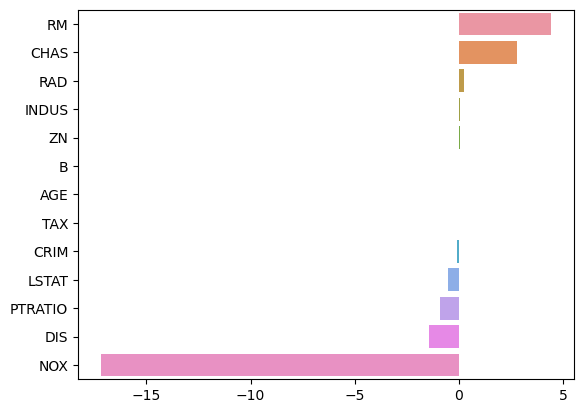

In [30]:
lin_coef = pd.Series(lin_reg.coef_, index=X_train.columns)
lin_coef_sort = lin_coef.sort_values(ascending=False)
sns.barplot(x=lin_coef_sort.values, y=lin_coef_sort.index)
plt.show()

- 릿지 회귀(Ridge)

In [35]:
alphas = [0, 0.1, 1, 10, 100]

coef_df = pd.DataFrame()
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha, random_state=42)
    ridge_reg.fit(X_train, y_train)
    
    ridge_coef = pd.Series(ridge_reg.coef_, index=X_train.columns)
    ridge_coef_sort = ridge_coef.sort_values(ascending=False)
    
    column = 'alpha : ' + str(alpha)
    coef_df[column] = ridge_coef_sort # 위의 컬럼 내용을 데이터 프레임에 하나씩 추가

coef_df

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,4.438835,4.445779,4.464505,4.195326,2.438815
CHAS,2.784438,2.750333,2.545470,1.813291,0.550702
RAD,0.262430,0.260043,0.248882,0.248031,0.299014
INDUS,0.040381,0.034896,0.007498,-0.026277,-0.048625
ZN,0.030110,0.030459,0.032271,0.035552,0.039892
B,0.012351,0.012400,0.012642,0.012833,0.011951
AGE,-0.006296,-0.007305,-0.012191,-0.015341,0.000545
TAX,-0.010647,-0.010780,-0.011475,-0.012744,-0.014630
CRIM,-0.113056,-0.112400,-0.109234,-0.107134,-0.110765
LSTAT,-0.508571,-0.510902,-0.523833,-0.561835,-0.689539


- 라쏘 회귀(Lasso)

In [36]:
alphas = [0.05, 0.1, 0.2, 0.5, 1]

coef_df = pd.DataFrame()
for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha, random_state=42)
    lasso_reg.fit(X_train, y_train)
    
    lasso_coef = pd.Series(lasso_reg.coef_, index=X_train.columns)
    lasso_coef_sort = lasso_coef.sort_values(ascending=False)
    
    column = 'alpha : ' + str(alpha)
    coef_df[column] = lasso_coef_sort # 위의 컬럼 내용을 데이터 프레임에 하나씩 추가

coef_df

,alpha : 0.05,alpha : 0.1,alpha : 0.2,alpha : 0.5,alpha : 1
RM,4.443676,4.311687,4.026917,3.129886,1.630489
CHAS,1.704029,0.919952,0.000000,0.000000,0.000000
RAD,0.234443,0.239237,0.245289,0.236596,0.219654
ZN,0.034602,0.034893,0.034848,0.032640,0.028501
B,0.013035,0.013091,0.013039,0.012350,0.011181
TAX,-0.012599,-0.012962,-0.013317,-0.013032,-0.012286
AGE,-0.017338,-0.015126,-0.010294,0.000000,0.016395
INDUS,-0.023023,-0.016785,-0.005376,-0.000000,-0.000000
CRIM,-0.104256,-0.104157,-0.103020,-0.093034,-0.076609
NOX,-0.524613,-0.000000,-0.000000,-0.000000,-0.000000


- 엘라스틱넷(ElasticNet)

In [37]:
alphas = [0.05, 0.1, 0.2, 0.5, 1]

coef_df = pd.DataFrame()
for alpha in alphas:
    elastic_reg = ElasticNet(alpha=alpha, random_state=42)
    elastic_reg.fit(X_train, y_train)
    
    elastic_coef = pd.Series(elastic_reg.coef_, index=X_train.columns)
    elastic_coef_sort = elastic_coef.sort_values(ascending=False)
    
    column = 'alpha : ' + str(alpha)
    coef_df[column] = elastic_coef_sort # 위의 컬럼 내용을 데이터 프레임에 하나씩 추가

coef_df

,alpha : 0.05,alpha : 0.1,alpha : 0.2,alpha : 0.5,alpha : 1
RM,4.134773,3.764341,3.160552,2.051658,1.162996
CHAS,1.521003,0.977221,0.404020,0.000000,0.000000
RAD,0.247966,0.258443,0.273963,0.287364,0.275980
ZN,0.035809,0.037015,0.038071,0.037961,0.035571
B,0.012867,0.012746,0.012439,0.011721,0.011013
TAX,-0.012941,-0.013479,-0.014028,-0.014505,-0.014273
AGE,-0.014885,-0.011703,-0.005211,0.006508,0.018591
INDUS,-0.027025,-0.030900,-0.031594,-0.030560,-0.020130
CRIM,-0.106450,-0.106853,-0.107092,-0.103047,-0.093299
LSTAT,-0.569848,-0.600051,-0.644219,-0.719262,-0.775576


**참고**

- 정규화(0~1 사이로 변환)

In [38]:
def minmax_normalize(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

In [40]:
X = np.arange(10)
X_normalized = minmax_normalize(X)
X_normalized.min(), X_normalized.max()

(0.0, 1.0)

- 표준화 (평균 0, 표준편차 1)

In [39]:
def zscore_standize(arr): # 평균 0, 표준편차 1
    return (arr - arr.mean())/arr.std()

In [41]:
X = np.arange(10)
X_standardized = zscore_standize(X)
X_standardized.mean(), X_standardized.std()

(-6.661338147750939e-17, 1.0)